<a href="https://www.kaggle.com/code/ammarbkhet/ci-v2?scriptVersionId=215151383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import os
import random
from PIL import Image
import numpy as np

# Parameters
base_dir = "/kaggle/input/d/ntl0601/casia-webface/casia-webface"  # Path to the dataset directory
num_classes = 75  # Number of classes to load
images_per_class = 200  # Number of images per class
target_size = (128, 128)  # Resize images to this size (height, width)

# Helper function to load images
def load_images_from_class(class_path, num_images, target_size):
    # Get all image filenames in the class folder
    image_files = os.listdir(class_path)
    image_paths = [os.path.join(class_path, img) for img in image_files]

    # Randomly sample 'num_images' from the available images
    sampled_paths = random.sample(image_paths, num_images)

    # Load and process images
    images = []
    for path in sampled_paths:
        try:
            img = Image.open(path).convert("RGB")  # Ensure RGB format
            img = img.resize(target_size)  # Resize to target size
            images.append(np.array(img))  # Convert to NumPy array
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    
    return np.array(images)

# Load dataset
def load_dataset(base_dir, num_classes, images_per_class, target_size):
    # Get all class folders
    class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

    # Filter classes with at least 'images_per_class' images
    eligible_classes = []
    for class_name in class_folders:
        class_path = os.path.join(base_dir, class_name)
        if len(os.listdir(class_path)) >= images_per_class:
            eligible_classes.append(class_name)

    # Ensure enough eligible classes are available
    if len(eligible_classes) < num_classes:
        raise ValueError(f"Not enough classes with at least {images_per_class} images. Found only {len(eligible_classes)} eligible classes.")
    
    # Randomly select 'num_classes' from eligible classes
    selected_classes = random.sample(eligible_classes, num_classes)
    
    dataset = []
    labels = []
    for label, class_name in enumerate(selected_classes):  # Sequential labels from 0 to num_classes-1
        class_path = os.path.join(base_dir, class_name)
        print(f"Loading class: {class_name} -> Label: {label}")
        
        # Load images from the class
        images = load_images_from_class(class_path, images_per_class, target_size)
        dataset.append(images)
        labels.extend([label] * images.shape[0])  # Assign sequential label to all images in the class
    
    # Combine and shuffle the dataset
    dataset = np.vstack(dataset)  # Stack all images into a single array
    labels = np.array(labels)
    
    # Shuffle the data
    indices = np.arange(dataset.shape[0])
    np.random.shuffle(indices)
    dataset = dataset[indices]
    labels = labels[indices]
    
    return dataset, labels

# Load dataset with 100 classes and 200 images each
all_images, all_labels = load_dataset(base_dir, num_classes, images_per_class, target_size)

# Dataset shape
print(f"Dataset shape: {all_images.shape}")  # (total_images, height, width, channels)
print(f"Labels shape: {all_labels.shape}")    # (total_images,)


Loading class: 000536 -> Label: 0
Loading class: 004862 -> Label: 1
Loading class: 004728 -> Label: 2
Loading class: 006332 -> Label: 3
Loading class: 002027 -> Label: 4
Loading class: 000372 -> Label: 5
Loading class: 001222 -> Label: 6
Loading class: 000976 -> Label: 7
Loading class: 001264 -> Label: 8
Loading class: 005065 -> Label: 9
Loading class: 007300 -> Label: 10
Loading class: 008855 -> Label: 11
Loading class: 000343 -> Label: 12
Loading class: 000986 -> Label: 13
Loading class: 000198 -> Label: 14
Loading class: 004178 -> Label: 15
Loading class: 005015 -> Label: 16
Loading class: 007030 -> Label: 17
Loading class: 002834 -> Label: 18
Loading class: 000467 -> Label: 19
Loading class: 002738 -> Label: 20
Loading class: 007766 -> Label: 21
Loading class: 005547 -> Label: 22
Loading class: 000101 -> Label: 23
Loading class: 000254 -> Label: 24
Loading class: 003749 -> Label: 25
Loading class: 001501 -> Label: 26
Loading class: 000022 -> Label: 27
Loading class: 000069 -> Label

In [ ]:
# Save the arrays
np.save('all_images.npy', all_images)
np.save('all_labels.npy', all_labels)

In [ ]:
# Load the arrays later
loaded_images = np.load('all_images.npy')
loaded_labels = np.load('all_labels.npy')

In [3]:
import tensorflow as tf
import numpy as np

# Function to standardize each batch
def standardize_batch(batch):
    # Calculate mean and standard deviation for each batch
    batch_mean = np.mean(batch, axis=(0, 1, 2), keepdims=True)  # Mean across height, width, channels
    batch_std = np.std(batch, axis=(0, 1, 2), keepdims=True)  # Standard deviation across height, width, channels
    
    # Standardize the batch
    standardized_batch = (batch - batch_mean) / batch_std
    # standardized_batch = batch 
    return standardized_batch

# Define batch size
batch_size = 50

# Initialize a list to store all the normalized data
normalized_data = []

# Loop through the dataset in batches of size 'batch_size'
for start_idx in range(0, len(all_images), batch_size):
    # Get the end index for the current batch
    end_idx = min(start_idx + batch_size, len(all_images))
    
    # Get the current batch of images and labels
    images_batch = all_images[start_idx:end_idx]
    labels_batch = all_labels[start_idx:end_idx]
    
    # Standardize the current batch of images
    standardized_images = standardize_batch(images_batch)
    
    # Append the standardized images to the normalized_data list
    normalized_data.append(standardized_images)

# Convert the normalized data list into a numpy array
normalized_data = np.concatenate(normalized_data, axis=0)

# Print the shape of the normalized data
print(f"Normalized data shape: {normalized_data.shape}")


Normalized data shape: (15000, 128, 128, 3)


In [ ]:
# Save the arrays
np.save('normalized_data.npy', normalized_data)

In [ ]:
# Load the arrays later
loaded_images = np.load('normalized_data.npy')

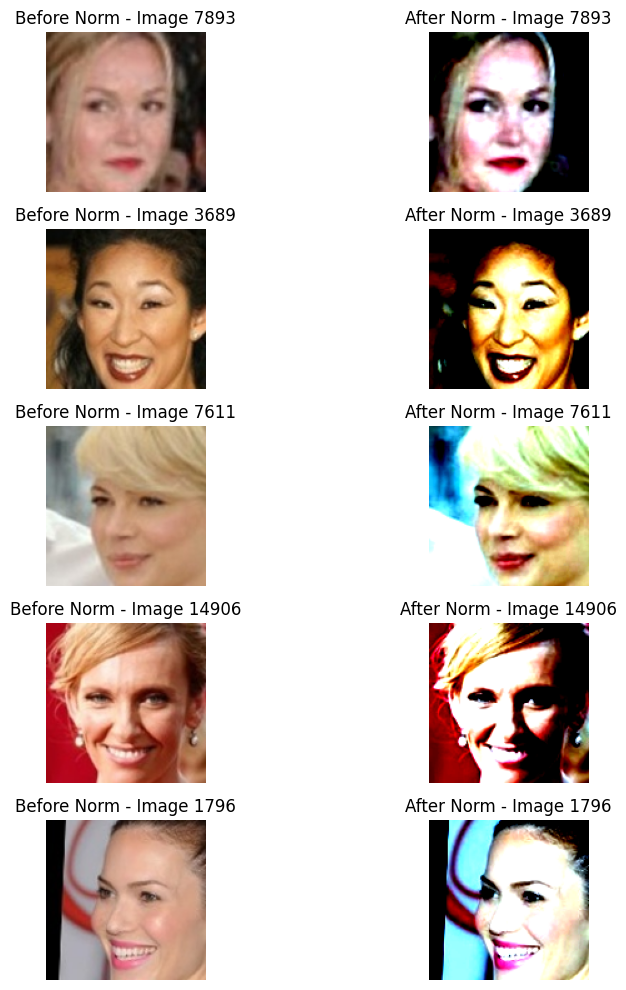

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize random images before and after normalization
def visualize_images(before, after, n=5):
    # Generate random indices
    indices = np.random.choice(before.shape[0], n, replace=False)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(n, 2, figsize=(10, 2*n))
    
    for i, idx in enumerate(indices):
        # Plot before normalization
        axs[i, 0].imshow(before[idx].astype('uint8'))
        axs[i, 0].set_title(f"Before Norm - Image {idx}")
        axs[i, 0].axis('off')  # Hide axes
        
        # Plot after normalization
        axs[i, 1].imshow(after[idx])
        axs[i, 1].set_title(f"After Norm - Image {idx}")
        axs[i, 1].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

# Visualize 5 random images before and after normalization
visualize_images(all_images, normalized_data, n=5)


In [5]:
# Splitting the data to training and testing and validation 
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(normalized_data, all_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#printing the shape of each split
print(f"X_train shape is :{X_train.shape}")
print(f"X_val shape is :{X_val.shape}")
print(f"X_test shape is :{X_test.shape}")
print(f"y_train shape is :{y_train.shape}")
print(f"y_val shape is :{y_val.shape}")
print(f"y_test shape is :{y_test.shape}")


X_train shape is :(10500, 128, 128, 3)
X_val shape is :(2250, 128, 128, 3)
X_test shape is :(2250, 128, 128, 3)
y_train shape is :(10500,)
y_val shape is :(2250,)
y_test shape is :(2250,)


In [6]:
# Normalize the Data 
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
# Vanilla AutoEncoder 0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# # Input shape based on your data for old data
# input_shape = (112, 96, 3)
# flat_input_shape = 112 * 96 * 3
input_shape = (128, 128, 3)
flat_input_shape = 128 * 128 * 3

# Encoder
encoder_input = keras.Input(shape=(flat_input_shape,), name="encoder_input")
x = layers.Dense(512, activation="relu")(encoder_input)  
x = layers.Dense(256, activation="relu")(x)  
x = layers.Dense(128, activation="relu")(x)  
encoder_output = layers.Dense(64, name="encoder_output")(x) 

encoder_va0 = keras.Model(encoder_input, encoder_output, name="encoder")
encoder_va0.summary()

# Decoder
decoder_input = keras.Input(shape=(64,), name="decoder_input")
x = layers.Dense(128, activation="relu")(decoder_input)  
x = layers.Dense(256, activation="relu")(x)  
x = layers.Dense(512, activation="relu")(x)  
decoder_output = layers.Dense(flat_input_shape, activation="sigmoid", name="decoder_output")(x)  

decoder_va0 = keras.Model(decoder_input, decoder_output, name="decoder")
decoder_va0.summary()

# Autoencoder
autoencoder_input = keras.Input(shape=input_shape, name="autoencoder_input")
flat_autoencoder_input = layers.Flatten()(autoencoder_input)
encoded = encoder_va0(flat_autoencoder_input)
decoded = decoder_va0(encoded)
reshaped_decoded = layers.Reshape(input_shape)(decoded)
Vanilla_autoencoder = keras.Model(autoencoder_input, reshaped_decoded, name="autoencoder")
Vanilla_autoencoder.summary()




Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,166,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,338,816 (96.66 MB)

 Trainable params: 25,338,816 (96.66 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (None, 49152)               │      25,214,976 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,387,904 (96.85 MB)

 Trainable params: 25,387,904 (96.85 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │      25,338,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 49152)               │      25,387,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,726,720 (193.51 MB)

 Trainable params: 50,726,720 (193.51 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Vanilla autoendoer 1

# Encoder
encoder_input_1 = keras.Input(shape=(flat_input_shape,), name="encoder_input_1")
x = layers.Dense(256, activation="relu")(encoder_input_1)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
encoder_output_1 = layers.Dense(32, name="encoder_output_1")(x)

encoder_va1 = keras.Model(encoder_input_1, encoder_output_1, name="encoder_1")
encoder_va1.summary()

# Decoder
decoder_input_1 = keras.Input(shape=(32,), name="decoder_input_1")
x = layers.Dense(64, activation="relu")(decoder_input_1)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
decoder_output_1 = layers.Dense(flat_input_shape, activation="sigmoid", name="decoder_output_1")(x)

decoder_va1 = keras.Model(decoder_input_1, decoder_output_1, name="decoder_1")
decoder_va1.summary()

# Autoencoder
autoencoder_input_1 = keras.Input(shape=input_shape, name="autoencoder_input_1")
flat_autoencoder_input_1 = layers.Flatten()(autoencoder_input_1)
encoded_1 = encoder_va1(flat_autoencoder_input_1)
decoded_1 = decoder_va1(encoded_1)
reshaped_decoded_1 = layers.Reshape(input_shape)(decoded_1)
Vanilla_autoencoder_1 = keras.Model(autoencoder_input_1, reshaped_decoded_1, name="autoencoder_1")
Vanilla_autoencoder_1.summary()


Model: "encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input_1 (InputLayer)         │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      12,583,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output_1 (Dense)             │ (None, 32)                  │           2,080 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,626,400 (48.17 MB)

 Trainable params: 12,626,400 (48.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input_1 (InputLayer)         │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output_1 (Dense)             │ (None, 49152)               │      12,632,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,675,520 (48.35 MB)

 Trainable params: 12,675,520 (48.35 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ autoencoder_input_1 (InputLayer)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1 (Functional)               │ (None, 32)                  │      12,626,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Functional)               │ (None, 49152)               │      12,675,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,301,920 (96.52 MB)

 Trainable params: 25,301,920 (96.52 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Vanilla autoencoder 2

# Encoder
encoder_input_2 = keras.Input(shape=(flat_input_shape,), name="encoder_input_2")
x = layers.Dense(1024, activation="relu")(encoder_input_2)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
encoder_output_2 = layers.Dense(128, name="encoder_output_2")(x)

encoder_va2 = keras.Model(encoder_input_2, encoder_output_2, name="encoder_2")
encoder_va2.summary()

# Decoder
decoder_input_2 = keras.Input(shape=(128,), name="decoder_input_2")
x = layers.Dense(256, activation="relu")(decoder_input_2)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
decoder_output_2 = layers.Dense(flat_input_shape, activation="sigmoid", name="decoder_output_2")(x)

decoder_va2 = keras.Model(decoder_input_2, decoder_output_2, name="decoder_2")
decoder_va2.summary()

# Autoencoder
autoencoder_input_2 = keras.Input(shape=input_shape, name="autoencoder_input_2")
flat_autoencoder_input_2 = layers.Flatten()(autoencoder_input_2)
encoded_2 = encoder_va2(flat_autoencoder_input_2)
decoded_2 = decoder_va2(encoded_2)
reshaped_decoded_2 = layers.Reshape(input_shape)(decoded_2)
Vanilla_autoencoder_2 = keras.Model(autoencoder_input_2, reshaped_decoded_2, name="autoencoder_2")
Vanilla_autoencoder_2.summary()


Model: "encoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input_2 (InputLayer)         │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │      50,332,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output_2 (Dense)             │ (None, 128)                 │          32,896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,021,696 (194.63 MB)

 Trainable params: 51,021,696 (194.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input_2 (InputLayer)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output_2 (Dense)             │ (None, 49152)               │      50,380,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,070,720 (194.82 MB)

 Trainable params: 51,070,720 (194.82 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ autoencoder_input_2 (InputLayer)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2 (Functional)               │ (None, 128)                 │      51,021,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Functional)               │ (None, 49152)               │      51,070,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,092,416 (389.45 MB)

 Trainable params: 102,092,416 (389.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.3849 - loss: 0.0342 - val_accuracy: 0.4197 - val_loss: 1.5439e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4238 - loss: 1.5422e-05 - val_accuracy: 0.4197 - val_loss: 1.5439e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4263 - loss: 1.5320e-05 - val_accuracy: 0.4197 - val_loss: 1.5439e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4227 - loss: 1.5358e-05 - val_accuracy: 0.4197 - val_loss: 1.5439e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4178 - loss: 1.5379e-05 - val_accuracy: 0.4198 - val_loss: 1.5439e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4205 - loss: 1.5422e-05 - val_accuracy: 0.4198 - val_loss: 1.5439e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4267 - loss: 1.5361e-05 - val_accuracy: 0.4198 - val_loss: 1.5439e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 1

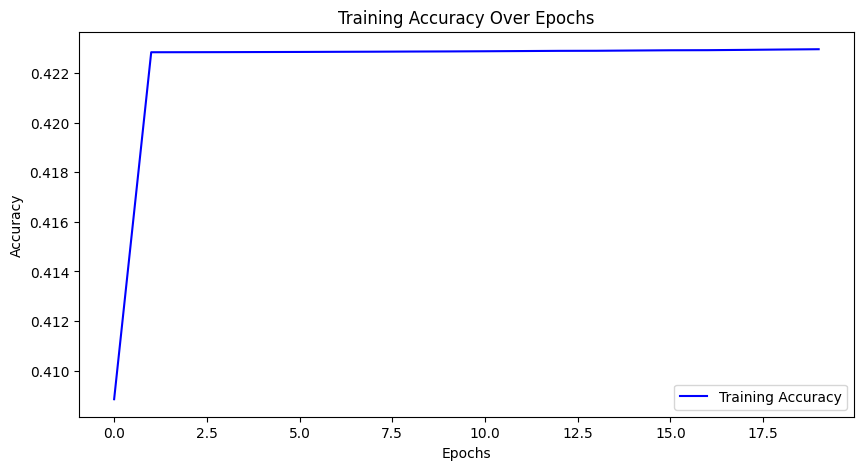

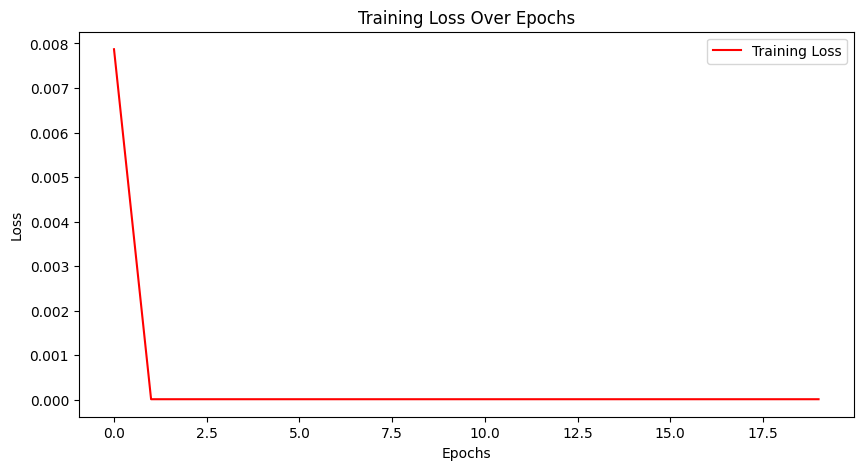

In [10]:
# Compile the Vanilla autoencoder 0 and save the Model
Vanilla_autoencoder.compile(optimizer="Nadam", loss="mse", metrics=['accuracy'])



# Reshape input data for dense layers
X_train_flat = X_train.reshape(X_train.shape[0], flat_input_shape)
X_val_flat = X_val.reshape(X_val.shape[0], flat_input_shape)
X_test_flat = X_test.reshape(X_test.shape[0], flat_input_shape)

# Train the autoencoder
num1 = Vanilla_autoencoder.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

# Evaluate the autoencoder
loss, accuracy = Vanilla_autoencoder.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy*100:.2f}%")

Vanilla_autoencoder.save("Vanilla_autoencoder_0_model.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num1.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num1.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3722 - loss: 0.0974 - val_accuracy: 0.4261 - val_loss: 1.5757e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4289 - loss: 1.5519e-05 - val_accuracy: 0.4262 - val_loss: 1.5656e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4255 - loss: 1.5441e-05 - val_accuracy: 0.4264 - val_loss: 1.5594e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4275 - loss: 1.5353e-05 - val_accuracy: 0.4266 - val_loss: 1.5550e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4325 - loss: 1.5320e-05 - val_accuracy: 0.4269 - val_loss: 1.5521e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4325 - loss: 1.5358e-05 - val_accuracy: 0.4272 - val_loss: 1.5503e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4299 - loss: 1.5482e-05 - val_accuracy: 0.4275 - val_loss: 1.5489e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14

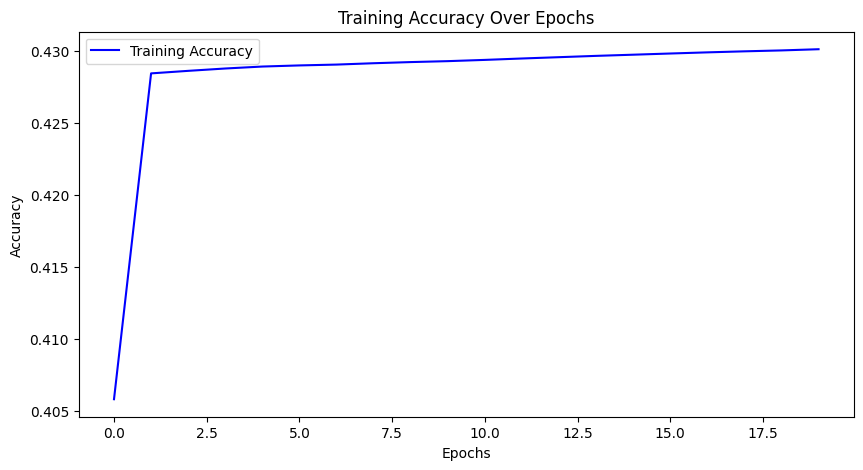

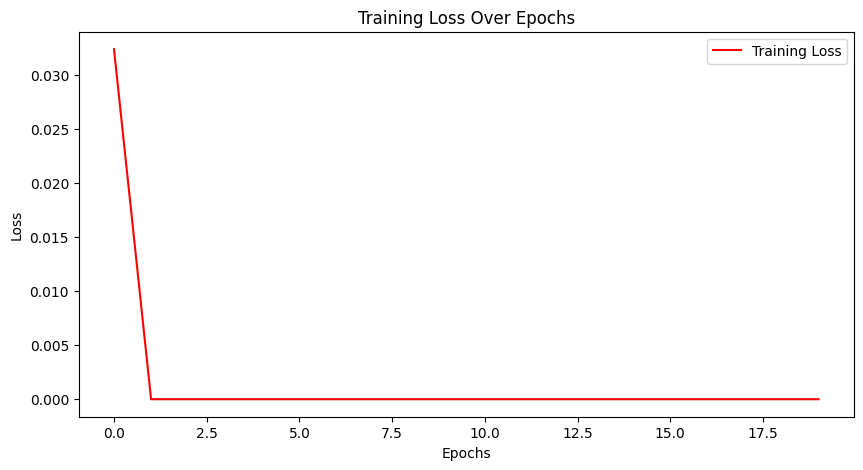

In [11]:
# Compile the Vanilla autoencoder 1 and save the Model
Vanilla_autoencoder_1.compile(optimizer="adam", loss="mse", metrics=['accuracy'])



# Reshape input data for dense layers
X_train_flat = X_train.reshape(X_train.shape[0], flat_input_shape)
X_val_flat = X_val.reshape(X_val.shape[0], flat_input_shape)
X_test_flat = X_test.reshape(X_test.shape[0], flat_input_shape)

# Train the autoencoder
num2 = Vanilla_autoencoder_1.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

# Evaluate the autoencoder
loss, accuracy = Vanilla_autoencoder_1.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy*100:.2f}%")

Vanilla_autoencoder_1.save("Vanilla_autoencoder_1_model.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num2.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num2.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4077 - loss: 0.0684 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4418 - loss: 1.5360e-05 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4399 - loss: 1.5513e-05 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4465 - loss: 1.5361e-05 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4457 - loss: 1.5367e-05 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4453 - loss: 1.5445e-05 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4428 - loss: 1.5380e-05 - val_accuracy: 0.4394 - val_loss: 1.5423e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 3

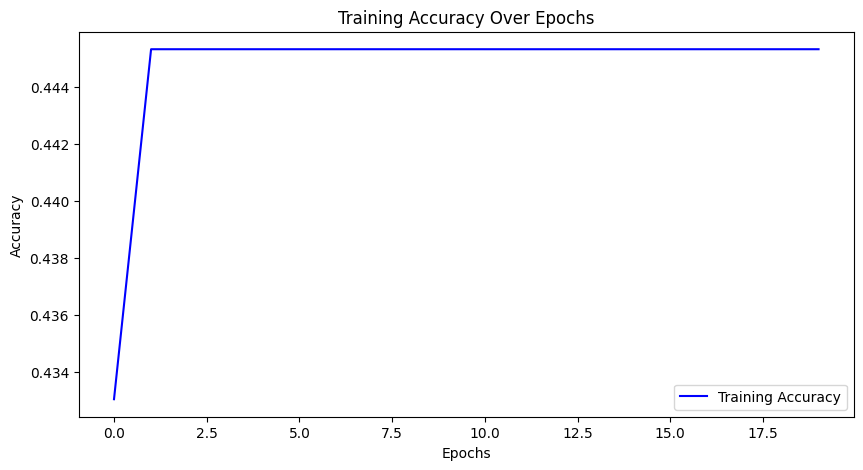

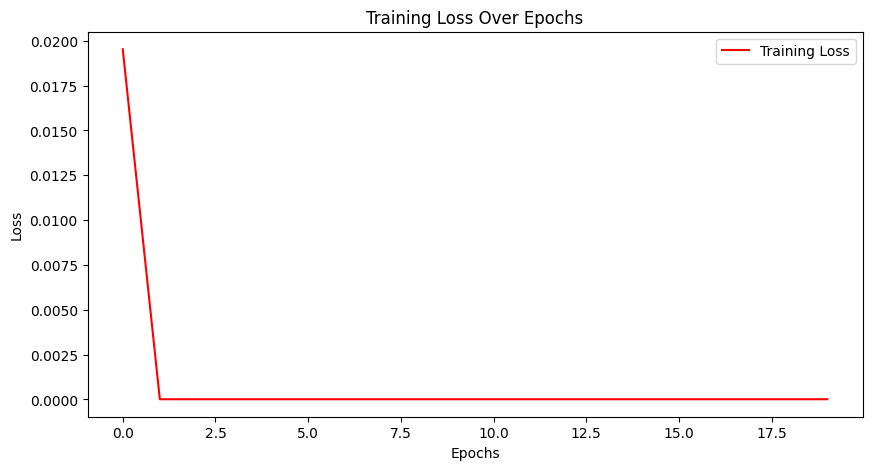

In [12]:
# Compile the Vanilla autoencoder 2 and save the Model
Vanilla_autoencoder_2.compile(optimizer="adam", loss="mse", metrics=['accuracy'])



# Reshape input data for dense layers
X_train_flat = X_train.reshape(X_train.shape[0], flat_input_shape)
X_val_flat = X_val.reshape(X_val.shape[0], flat_input_shape)
X_test_flat = X_test.reshape(X_test.shape[0], flat_input_shape)

# Train the autoencoder
num3 = Vanilla_autoencoder_2.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

# Evaluate the autoencoder
loss, accuracy = Vanilla_autoencoder_2.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy*100:.2f}%")

Vanilla_autoencoder_2.save("Vanilla_autoencoder_2_model.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num3.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num3.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
# def reconstruction_accuracy(y_true, y_pred, threshold=0.03):
#     """Calculates reconstruction accuracy based on a threshold."""
#     y_true_reshaped = tf.reshape(y_true, (-1, flat_input_shape))
#     y_pred_reshaped = tf.reshape(y_pred, (-1, flat_input_shape))
#     absolute_diff = tf.abs(y_true_reshaped - y_pred_reshaped)
#     correct_pixels = tf.reduce_sum(tf.cast(absolute_diff < threshold, tf.float32), axis=1)
#     total_pixels = flat_input_shape
#     accuracy = tf.reduce_mean(correct_pixels / total_pixels)
#     return accuracy

In [13]:
# Variational Model 0
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import numpy as np

# Input dimensions
input_shape = (128, 128, 3)
latent_dim = 64  # Dimensionality of the latent space
flattened_dim = np.prod(input_shape)  # Total number of elements in the input shape

# Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder_v0 = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_v0.summary()

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(flattened_dim, activation="sigmoid")(x)  # Use flattened_dim
decoder_outputs = layers.Reshape(input_shape)(x)

decoder_v0 = Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_v0.summary()

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder_v0
        self.decoder = decoder_v0

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return reconstructed



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 49152)          │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 512)            │     25,166,336 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 256)            │        131,328 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 128)            │         32,896 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │          8,256 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │          8,256 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,347,072 (96.69 MB)

 Trainable params: 25,347,072 (96.69 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 49152)               │      25,214,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,387,904 (96.85 MB)

 Trainable params: 25,387,904 (96.85 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Variational Model 1
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import numpy as np

# Input dimensions
input_shape = (128, 128, 3)
latent_dim = 64  # Dimensionality of the latent space
flattened_dim = np.prod(input_shape)  # Total number of elements in the input shape

# Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder_v1 = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_v1.summary()

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(64, activation="relu")(decoder_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(flattened_dim, activation="sigmoid")(x)  # Use flattened_dim
decoder_outputs = layers.Reshape(input_shape)(x)

decoder_v1 = Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_v1.summary()

# VAE Model
class VAE_1(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE_1, self).__init__(**kwargs)
        self.encoder = encoder_v1
        self.decoder = decoder_v1

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return reconstructed



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 49152)          │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 256)            │     12,583,168 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 128)            │         32,896 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 64)             │          8,256 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │          4,160 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │          4,160 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,632,640 (48.19 MB)

 Trainable params: 12,632,640 (48.19 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 49152)               │      12,632,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,677,568 (48.36 MB)

 Trainable params: 12,677,568 (48.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Variational Model 2
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import numpy as np

# Input dimensions
input_shape = (128, 128, 3)
latent_dim = 64  # Dimensionality of the latent space
flattened_dim = np.prod(input_shape)  # Total number of elements in the input shape

# Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder_v2 = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_v2.summary()

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(256, activation="relu")(decoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(flattened_dim, activation="sigmoid")(x)  # Use flattened_dim
decoder_outputs = layers.Reshape(input_shape)(x)

decoder_v2 = Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_v2.summary()

# VAE Model
class VAE_2(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE_2, self).__init__(**kwargs)
        self.encoder = encoder_v2
        self.decoder = decoder_v2

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return reconstructed



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 49152)          │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 1024)           │     50,332,672 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 512)            │        524,800 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 256)            │        131,328 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         16,448 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         16,448 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,021,696 (194.63 MB)

 Trainable params: 51,021,696 (194.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 49152)               │      50,380,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,054,336 (194.76 MB)

 Trainable params: 51,054,336 (194.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.3383 - loss: 0.0393 - val_accuracy: 0.3430 - val_loss: 1.5521e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3430 - loss: 1.5391e-05 - val_accuracy: 0.3430 - val_loss: 1.5695e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3430 - loss: 1.5593e-05 - val_accuracy: 0.3430 - val_loss: 1.5725e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3432 - loss: 1.5788e-05 - val_accuracy: 0.3430 - val_loss: 1.6082e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3431 - loss: 1.5790e-05 - val_accuracy: 0.3430 - val_loss: 1.5844e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3431 - loss: 1.5856e-05 - val_accuracy: 0.3430 - val_loss: 1.6112e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3430 - loss: 1.5875e-05 - val_accuracy: 0.3430 - val_loss: 1.6171e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 2

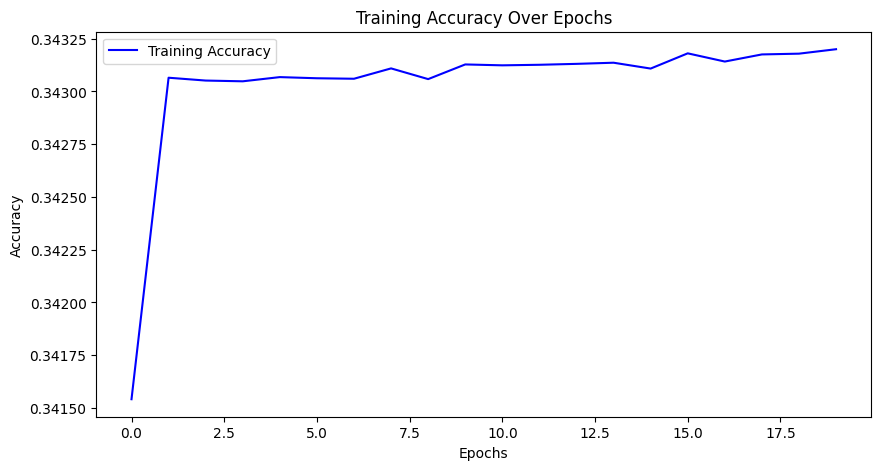

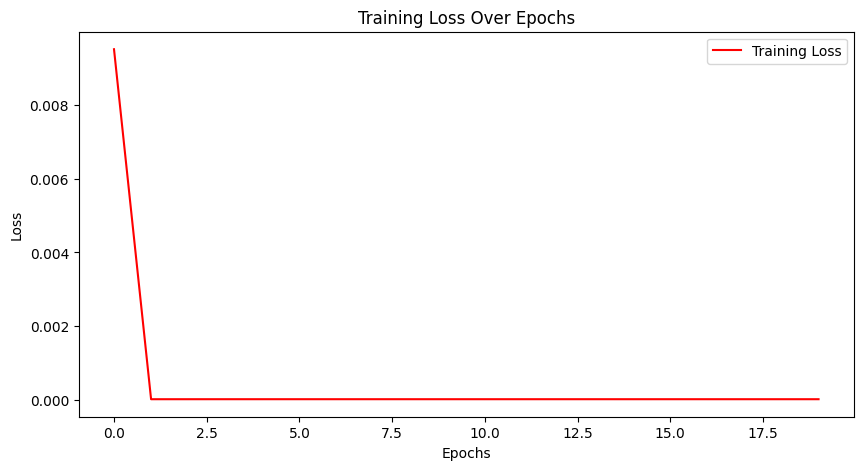

In [16]:
# Creating the VAE 0 Model

vae = VAE(encoder_v0, decoder_v0)

# Complie and save the Model of The VAE 0
vae.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# Train the VAE
num4 = vae.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

#print accuracy and loss
loss, accuracy = vae.evaluate(X_test, X_test)

print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
vae.save("vae_model_0.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num4.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num4.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3389 - loss: 0.0527 - val_accuracy: 0.3433 - val_loss: 1.5743e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3441 - loss: 1.6005e-05 - val_accuracy: 0.3461 - val_loss: 1.5913e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3466 - loss: 1.5853e-05 - val_accuracy: 0.3495 - val_loss: 1.5691e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3505 - loss: 1.5810e-05 - val_accuracy: 0.3535 - val_loss: 1.6148e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3545 - loss: 1.5735e-05 - val_accuracy: 0.3577 - val_loss: 1.6194e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3589 - loss: 1.6338e-05 - val_accuracy: 0.3625 - val_loss: 1.5933e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3638 - loss: 1.5685e-05 - val_accuracy: 0.3676 - val_loss: 1.5808e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14

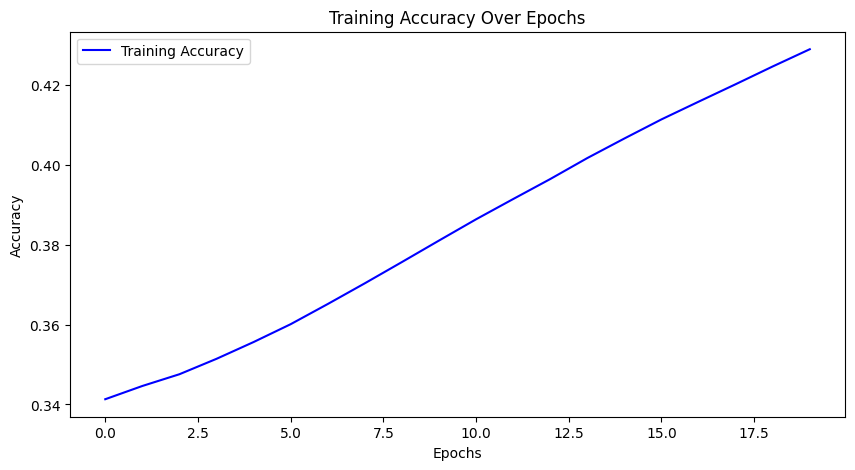

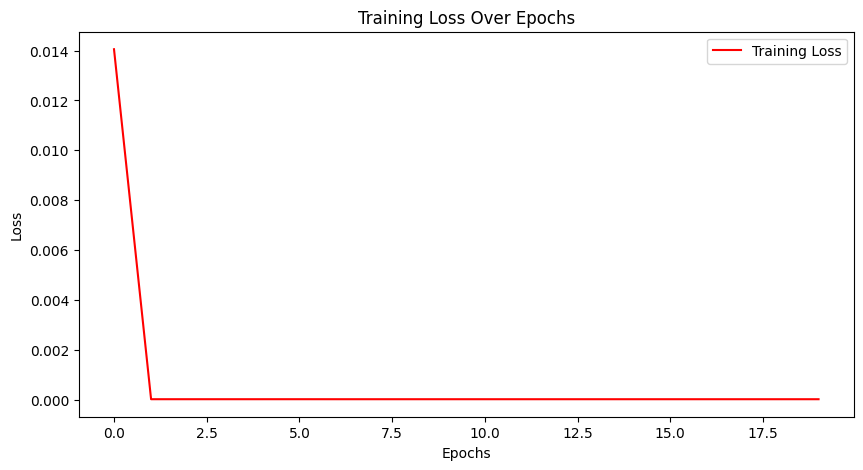

In [17]:
# Creating the VAE 1 Model
vae_1 = VAE_1(encoder_v1, decoder_v1)

# Complie and save the Model of The VAE 1
vae_1.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# Train the VAE
num5 = vae_1.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

#print accuracy and loss
loss, accuracy = vae_1.evaluate(X_test, X_test)

print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
vae_1.save("vae_model_1.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num5.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num5.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Creating the VAE 2 Model
vae_2 = VAE_2(encoder_v2, decoder_v2)

# Complie and save the Model of The VAE 1
vae_2.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# Train the VAE
vae_2.fit(X_train, X_train, epochs=50, batch_size=50, validation_data=(X_val, X_val))

#print accuracy and loss
loss, accuracy = vae_2.evaluate(X_test, X_test)

print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
vae_2.save("vae_model_2.h5")

In [18]:
# Conv autoecndoer 0

import tensorflow as tf
from tensorflow.keras import layers, Model

# Input dimensions
input_shape = (128, 128, 3)  # Example input image size

# Encoder
encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 64x64
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 32x32
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 16x16

# Latent space
latent_space = layers.Flatten()(x)  # Flatten the output from (16, 16, 128)
latent_space = layers.Dense(64, activation="relu")(latent_space)  # Dense layer for bottleneck

# Decoder
decoder_inputs = layers.Input(shape=(64,), name="decoder_input")
x = layers.Dense(16 * 16 * 128, activation="relu")(decoder_inputs)  # Dense to reshape into 3D space
x = layers.Reshape((16, 16, 128))(x)  # Reshape to match the 3D feature map shape (16x16x128)
x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 32x32
x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 64x64
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 128x128

# Final output layer
decoder_outputs = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Build the encoder and decoder models
encoder_c0 = Model(encoder_inputs, latent_space, name="encoder")
decoder_c0 = Model(decoder_inputs, decoder_outputs, name="decoder")

# Build the autoencoder model
Conv_autoencoder = Model(encoder_inputs, decoder_c0(encoder_c0(encoder_inputs)), name="autoencoder")



In [19]:
# Conv autoecndoer 1
from tensorflow.keras import layers, Model

from tensorflow.keras import layers, Model

# Input dimensions
input_shape = (128, 128, 3)

# Encoder - Variation 1 (Increased complexity)
encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 64x64
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 32x32
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 16x16

# Latent space
latent_space = layers.Flatten()(x)  # Flatten the output
latent_space = layers.Dense(128, activation="relu")(latent_space)  # Larger latent space

# Decoder - Variation 1 (Increased complexity)
decoder_inputs = layers.Input(shape=(128,), name="decoder_input")
x = layers.Dense(16 * 16 * 256, activation="relu")(decoder_inputs)  # Larger dense layer to reshape
x = layers.Reshape((16, 16, 256))(x)  # Reshape to match the 3D feature map shape (16x16x256)

# Upsampling layers
x = layers.Conv2DTranspose(256, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 32x32
x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 64x64
x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 128x128

# Final output layer
decoder_outputs = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Build the encoder and decoder models
encoder_c1 = Model(encoder_inputs, latent_space, name="encoder_1")
decoder_c1 = Model(decoder_inputs, decoder_outputs, name="decoder_1")

# Build the autoencoder model for Variation 1
Conv_autoencoder_1 = Model(encoder_inputs, decoder_c1(encoder_c1(encoder_inputs)), name="autoencoder_1")



In [20]:
# Conv autoecndoer 2

from tensorflow.keras import layers, Model

# Input dimensions
input_shape = (128, 128, 3)

# Encoder - Variation 2 (Reduced complexity)
encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 64x64
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 32x32
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsample to 16x16

# Latent space (Smaller latent space)
latent_space = layers.Flatten()(x)  # Flatten the output
latent_space = layers.Dense(32, activation="relu")(latent_space)  # Smaller latent space

# Decoder - Variation 2 (Reduced complexity)
decoder_inputs = layers.Input(shape=(32,), name="decoder_input")
x = layers.Dense(16 * 16 * 128, activation="relu")(decoder_inputs)  # Dense to reshape into 3D space
x = layers.Reshape((16, 16, 128))(x)  # Reshape to match the 3D feature map shape (16x16x128)

# Upsampling layers
x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 32x32
x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 64x64
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to 128x128

# Final output layer
decoder_outputs = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Build the encoder and decoder models
encoder_c2 = Model(encoder_inputs, latent_space, name="encoder_2")
decoder_c2 = Model(decoder_inputs, decoder_outputs, name="decoder_2")

# Build the autoencoder model for Variation 2
Conv_autoencoder_2 = Model(encoder_inputs, decoder_c2(encoder_c2(encoder_inputs)), name="autoencoder_2")



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │       2,190,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 128, 128, 3)         │       2,370,627 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,561,091 (17.40 MB)

 Trainable params: 4,561,091 (17.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.4477 - loss: 0.0304 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.4453 - loss: 1.5343e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.4459 - loss: 1.5288e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.4470 - loss: 1.5367e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.4471 - loss: 1.5408e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.4499 - loss: 1.5332e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.4436 - loss: 1.5441e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━

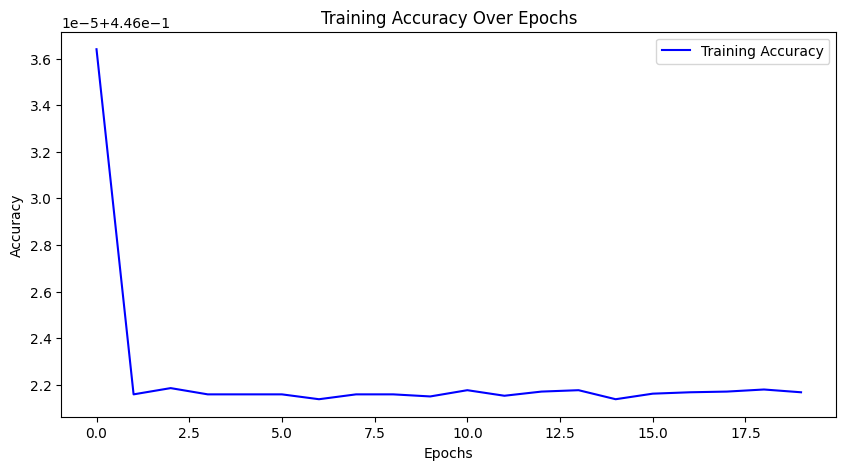

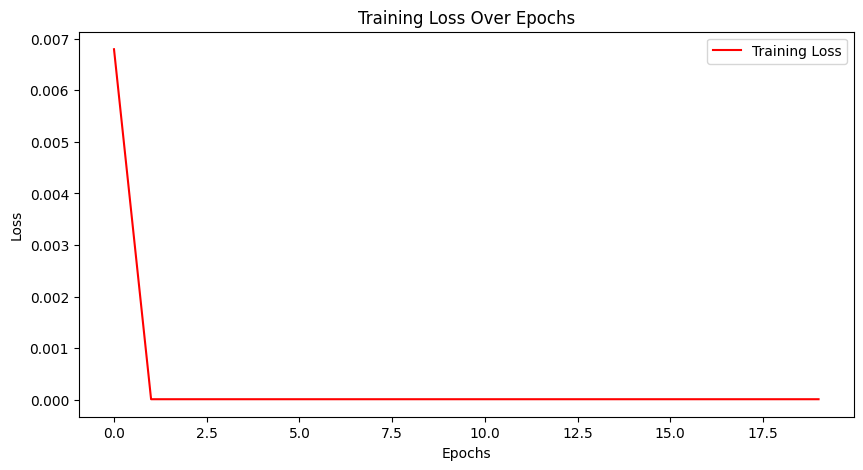

In [21]:
# Compile the model of the CONV 0
Conv_autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# Summary of the model architecture
Conv_autoencoder.summary()


# Train the model
num6 = Conv_autoencoder.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

loss, accuracy = Conv_autoencoder.evaluate(X_test, X_test)

print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
Conv_autoencoder.save("conv_autoencoder.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num6.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num6.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1 (Functional)               │ (None, 128)                 │       8,759,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Functional)               │ (None, 128, 128, 3)         │       9,414,787 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,174,339 (69.33 MB)

 Trainable params: 18,174,339 (69.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - accuracy: 0.3801 - loss: 0.0341 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - accuracy: 0.4406 - loss: 1.5475e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.4422 - loss: 1.5346e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.4447 - loss: 1.5425e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - accuracy: 0.4452 - loss: 1.5352e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.4469 - loss: 1.5387e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.4476 - loss: 1.5419e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━

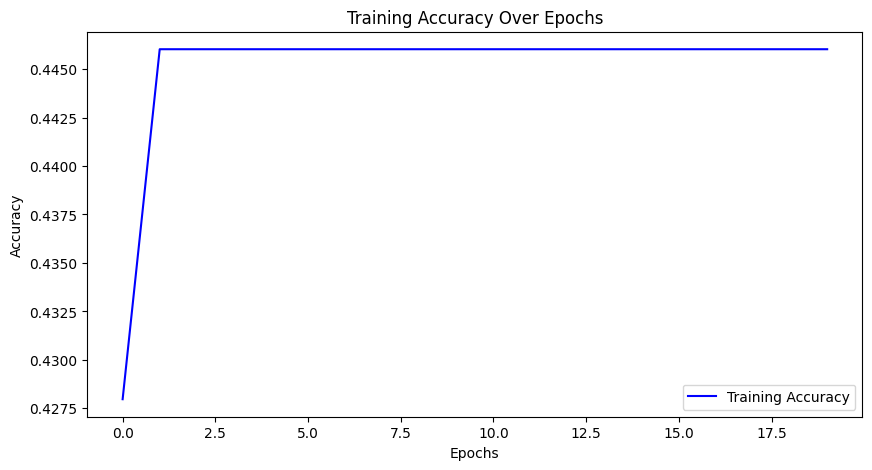

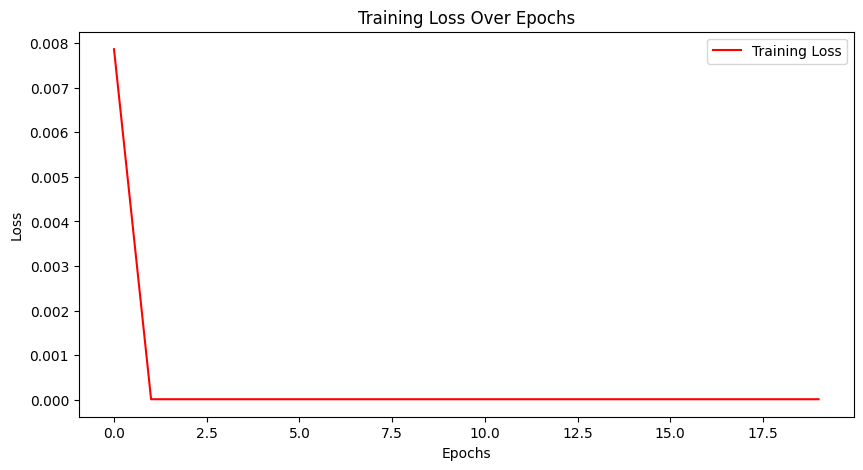

In [22]:
# Compile the model of the CONV 1
Conv_autoencoder_1.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# Summary of the model architecture
Conv_autoencoder_1.summary()


# Train the model
num7 = Conv_autoencoder_1.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

loss, accuracy = Conv_autoencoder_1.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
Conv_autoencoder_1.save("conv_autoencoder_1.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num7.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num7.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Model: "autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2 (Functional)               │ (None, 32)                  │       1,141,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Functional)               │ (None, 128, 128, 3)         │       1,322,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,463,907 (9.40 MB)

 Trainable params: 2,463,907 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.4411 - loss: 0.0463 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4464 - loss: 1.5444e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.4421 - loss: 1.5433e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.4468 - loss: 1.5270e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4455 - loss: 1.5309e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4482 - loss: 1.5349e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.4448 - loss: 1.5391e-05 - val_accuracy: 0.4398 - val_loss: 1.5423e-05
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━

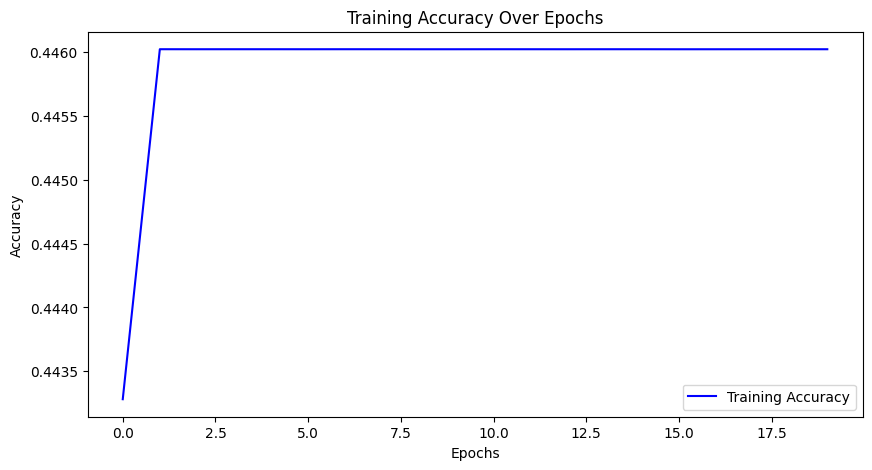

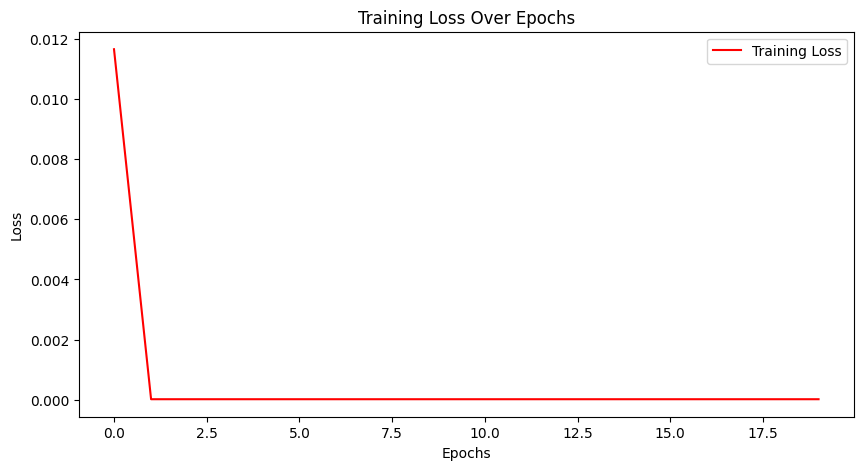

In [23]:
# Compile the model of the CONV 2
Conv_autoencoder_2.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

# Summary of the model architecture
Conv_autoencoder_2.summary()


# Train the model
num8 = Conv_autoencoder_2.fit(X_train, X_train, epochs=20, batch_size=50, validation_data=(X_val, X_val))

loss, accuracy = Conv_autoencoder_2.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
Conv_autoencoder_2.save("conv_autoencoder_2.h5")

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(num8.history['accuracy'], label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(num8.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [24]:
X_test_reshaped = X_test.reshape(-1, 49152)
X_train_reshaped = X_train.reshape(-1, 49152)
print(f"X_test_reshaped is {X_test_reshaped.shape}")
print(f"X_train_reshaped is {X_train_reshaped.shape}")

X_test_reshaped is (2250, 49152)
X_train_reshaped is (10500, 49152)


In [25]:
# Getting the features vectors out of different encoders
test_feature_vectors_va0 = np.array(encoder_va0.predict(X_test_reshaped))
z_mean_test, z_log_var_test, z_test = np.array(encoder_v0.predict(X_test))
test_feature_vectors_c0 = np.array(encoder_c0.predict(X_test))

# Store feature vectors of training data 
train_feature_vectors_va0 = np.array(encoder_va0.predict(X_train_reshaped))
z_mean_train, z_log_var_train, z_train = np.array(encoder_v0.predict(X_train))
train_feature_vectors_c0 = np.array(encoder_c0.predict(X_train))


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [26]:
print(f"train_feature_vectors_va0 is {train_feature_vectors_va0.shape}")
print(f"z_mean_train is {z_mean_train.shape}")
print(f"train_feature_vectors_c0 is {train_feature_vectors_c0.shape}")

train_feature_vectors_va0 is (10500, 64)
z_mean_train is (10500, 64)
train_feature_vectors_c0 is (10500, 64)


In [27]:
# euclidean_classifier

import numpy as np
from scipy.spatial.distance import cdist

def euclidean_classifier(train_features, train_labels, test_features):
    # Compute the Euclidean distances between each test feature and all training features
    distances = cdist(test_features, train_features, metric='euclidean')
    
    # For each test image, find the index of the closest (minimum distance) training feature vector
    predicted_labels = []
    for dist in distances:
        min_distance_index = np.argmin(dist)  # Index of minimum distance
        predicted_labels.append(train_labels[min_distance_index])  # Assign label of the closest training image
    
    return np.array(predicted_labels)




In [28]:
# Use the Euclidean classifier to classify the test images
predicted_labels_va0 = euclidean_classifier(train_feature_vectors_va0, y_train, test_feature_vectors_va0)
predicted_labels_v0 = euclidean_classifier(z_mean_train, y_train, z_mean_test)
predicted_labels_c0 = euclidean_classifier(train_feature_vectors_c0, y_train, test_feature_vectors_c0)

In [29]:
# Calculate recognition accuracy
from sklearn.metrics import accuracy_score

# Assuming you have the true labels for your test set
accuracy_va0 = accuracy_score(y_test, predicted_labels_va0)
accuracy_v0 = accuracy_score(y_test, predicted_labels_v0)
accuracy_c0 = accuracy_score(y_test, predicted_labels_c0)

print(f"Recognition accuracy out of vanilla : {accuracy_va0 * 100:.2f}%")
print(f"Recognition accuracy out of VAE: {accuracy_v0 * 100:.2f}%")
print(f"Recognition accuracy out of CONV: {accuracy_c0 * 100:.2f}%")


Recognition accuracy out of vanilla : 2.36%
Recognition accuracy out of VAE: 1.56%
Recognition accuracy out of CONV: 3.07%
